# Notebook Final: O que afeta a experiência e satisfação do cliente no e-commerce brasileiro

Este notebook reúne todo o fluxo de trabalho reproducível: carregamento dos dados, EDA, limpeza, transformações, engenharia de features, construção de pipelines e visualizações. Cada seção traz justificativa curta e um exemplo de código executável.

**Arquivos utilizados:**
- olist_orders_dataset.csv
- olist_order_items_dataset.csv
- olist_products_dataset.csv

## 1) Imports e configuração do ambiente



In [312]:

# Imports essenciais
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from datetime import datetime
import seaborn as sns
from typing import List , Dict , Tuple # Tipagem de funções 


# Mostrar versão e paths
print("Pandas:", pd.__version__)
DATA_DIR = "/datasets"
OUT_DIR = "/home/lacerda/projetos/saulopietro-Projeto-Analise-Exploratoria--Saulo-Davi-/output"
os.makedirs(OUT_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)


Pandas: 2.3.3
DATA_DIR: /datasets


## 2) Carregamento dos datasets



In [313]:
# Paths (ajuste se necessário)
p_orders = "datasets/olist_orders_dataset.csv"
p_order_items = "datasets/olist_order_items_dataset.csv"
p_products = "datasets/olist_products_dataset.csv"

# Carregar com inferência mínima para evitar erros de memória
orders = pd.read_csv(p_orders, low_memory=False)
order_items = pd.read_csv(p_order_items, low_memory=False)
products = pd.read_csv(p_products, low_memory=False)

print("orders:", orders.shape)
print("order_items:", order_items.shape)
print("products:", products.shape)

# Mostrar primeiras linhas para inspeção rápida
display(orders.head())
display(order_items.head())
display(products.head())


orders: (99441, 8)
order_items: (112650, 7)
products: (32951, 9)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


## 3) Merge dos datasets


In [314]:
orders = pd.read_csv("datasets/olist_orders_dataset.csv")
items = pd.read_csv("datasets/olist_order_items_dataset.csv")

df = orders.merge(items, on="order_id", how="inner")

products = pd.read_csv("datasets/olist_products_dataset.csv")

df = df.merge(products, on="product_id", how="left") 

df.to_csv("datasets/dataset_merged.csv",index=True)  


## Carregando dataset unido

In [315]:
df = pd.read_csv("datasets/dataset_merged.csv")

cols_to_drop = [
    "Unnamed: 0",
    "order_id",
    "customer_id",
    "product_id",
    "seller_id",
    "order_item_id",
    "product_name_lenght",
    "product_description_lenght"
]

df = df.drop(columns=cols_to_drop)

df.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,4.0,500.0,19.0,8.0,13.0
1,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-30 03:24:27,118.70,22.76,perfumaria,1.0,400.0,19.0,13.0,19.0
2,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-13 08:55:23,159.90,19.22,automotivo,1.0,420.0,24.0,19.0,21.0
3,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-23 19:45:59,45.00,27.20,pet_shop,3.0,450.0,30.0,10.0,20.0
4,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-19 20:31:37,19.90,8.72,papelaria,4.0,250.0,51.0,15.0,15.0


## 4) Entendimento inicial / EDA rápido


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_status                   112650 non-null  object 
 1   order_purchase_timestamp       112650 non-null  object 
 2   order_approved_at              112635 non-null  object 
 3   order_delivered_carrier_date   111456 non-null  object 
 4   order_delivered_customer_date  110196 non-null  object 
 5   order_estimated_delivery_date  112650 non-null  object 
 6   shipping_limit_date            112650 non-null  object 
 7   price                          112650 non-null  float64
 8   freight_value                  112650 non-null  float64
 9   product_category_name          111047 non-null  object 
 10  product_photos_qty             111047 non-null  float64
 11  product_weight_g               112632 non-null  float64
 12  product_length_cm             

In [317]:
df.head()

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,4.0,500.0,19.0,8.0,13.0
1,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-30 03:24:27,118.70,22.76,perfumaria,1.0,400.0,19.0,13.0,19.0
2,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-13 08:55:23,159.90,19.22,automotivo,1.0,420.0,24.0,19.0,21.0
3,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-23 19:45:59,45.00,27.20,pet_shop,3.0,450.0,30.0,10.0,20.0
4,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-19 20:31:37,19.90,8.72,papelaria,4.0,250.0,51.0,15.0,15.0


In [318]:
df.isnull().sum().sort_values(ascending=False)


order_delivered_customer_date    2454
product_category_name            1603
product_photos_qty               1603
order_delivered_carrier_date     1194
product_length_cm                  18
product_weight_g                   18
product_height_cm                  18
product_width_cm                   18
order_approved_at                  15
order_status                        0
order_purchase_timestamp            0
shipping_limit_date                 0
order_estimated_delivery_date       0
price                               0
freight_value                       0
dtype: int64

In [319]:
def collect_types_column(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    assert isinstance(df, pd.DataFrame), "O elemento de entrada não é um DataFrame"

    numeric_cols = df.select_dtypes(
        include=["int64", "float64", "int32", "float32"]
    ).columns.tolist()

    category_cols = df.select_dtypes(
        include=["object", "category", "string"]
    ).columns.tolist()

    return numeric_cols, category_cols

numerics , objects = collect_types_column(df) 


df[numerics].describe()


,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,112650.000000,112650.000000,111047.000000,112632.000000,112632.000000,112632.000000,112632.000000
mean,120.653739,19.990320,2.209713,2093.672047,30.153669,16.593766,22.996546
std,183.633928,15.806405,1.721438,3751.596884,16.153449,13.443483,11.707268
min,0.850000,0.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,39.900000,13.080000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,74.990000,16.260000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,134.900000,21.150000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,6735.000000,409.680000,20.000000,40425.000000,105.000000,105.000000,118.000000


## 5) Limpeza de dados

Tratar duplicatas, valores ausentes, inconsistências e outliers.

Para cada ação: breve justificativa + código de exemplo.

In [320]:
# Duplicatas exatas
n_dup = df.duplicated().sum()
print('Duplicatas exatas:', n_dup)
df = df.drop_duplicates()

# Exemplo: colunas de data -> converter para datetime quando existirem
date_cols = [c for c in df.columns if 'date' in c or 'timestamp' in c]
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
    except Exception as e:
        pass
print('Colunas de data detectadas:', date_cols)

# Valores ausentes por coluna (top 20)
missing = df.isna().sum().sort_values(ascending=False).head(20)
display(missing)


Duplicatas exatas: 10424
Colunas de data detectadas: ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']


/tmp/ipykernel_27000/1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_27000/1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
/tmp/ipykernel_27000/1446180909.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-

order_delivered_customer_date    2225
product_category_name            1458
product_photos_qty               1458
order_delivered_carrier_date     1027
product_length_cm                  16
product_weight_g                   16
product_height_cm                  16
product_width_cm                   16
order_approved_at                  14
order_status                        0
order_purchase_timestamp            0
shipping_limit_date                 0
order_estimated_delivery_date       0
price                               0
freight_value                       0
dtype: int64

### 5.1) Tratamento de `price`, `freight_value` e colunas textuais


In [321]:
# Assegurar price numérico e preencher NA com mediana por product_id quando disponível
# --- Price: converter e preencher por mediana por product_id com fallback global ---
if 'price' in df.columns:
    # garantir numérico
    df.loc[:, 'price'] = pd.to_numeric(df['price'], errors='coerce')

    # mediana por product_id
    if 'product_id' in df.columns:
        med_by_prod = df.groupby('product_id')['price'].median()
        # mapear a mediana por product_id e preencher só onde price é NA
        df.loc[:, 'price_fill_by_prod'] = df['product_id'].map(med_by_prod)
        # onde price está NA, usar mediana do produto; se também for NA, usar global
        median_global = df['price'].median()
        df.loc[:, 'price'] = df['price'].fillna(df['price_fill_by_prod']).fillna(median_global)
        # remover coluna auxiliar
        df.drop(columns=['price_fill_by_prod'], inplace=True)
    else:
        # sem product_id disponível, usa mediana global
        median_global = df['price'].median()
        df.loc[:, 'price'] = df['price'].fillna(median_global)

    print('Price median used (global fallback):', float(median_global))

# --- freight_value: converter e preencher NA com 0.0 (ou outra estratégia) ---
if 'freight_value' in df.columns:
    df.loc[:, 'freight_value'] = pd.to_numeric(df['freight_value'], errors='coerce').fillna(0.0)

# --- Padronizar colunas textuais (strip + lower) sem chained assignment ---
text_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in text_cols:
    # transformar para string (para evitar erros com NaN), limpar espaços e normalizar case
    # fazemos a atribuição via loc para evitar warning de cópia
    cleaned = df[c].astype(str).str.strip().str.lower().replace({'nan': 'unknown', 'none': 'unknown', '': 'unknown'})
    df.loc[:, c] = cleaned

Price median used (global fallback): 78.9


### 5.2) Detectar outliers (exemplo rápido)


In [322]:
# Criar days_to_deliver se possível
if {'order_purchase_timestamp','order_delivered_customer_date'}.issubset(df.columns):
    df['days_to_deliver'] = (pd.to_datetime(df['order_delivered_customer_date']) - pd.to_datetime(df['order_purchase_timestamp'])).dt.days

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

# Exemplo para price
if 'price' in df.columns:
    out_price = detect_outliers_iqr(df['price'].dropna())
    print('Outliers price (sample):', out_price.head().to_dict())

if 'days_to_deliver' in df.columns:
    out_days = detect_outliers_iqr(df['days_to_deliver'].dropna())
    print('Outliers days_to_deliver (count):', out_days.shape[0])


Outliers price (sample): {17: 1299.0, 40: 445.0, 43: 339.0, 56: 369.0, 66: 299.0}
Outliers days_to_deliver (count): 5116


## 6) Conversão e padronização de tipos


In [323]:
# Forçar tipos numéricos em colunas esperadas
num_guesses = ['price','freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm']
for c in num_guesses:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Identificar colunas categóricas candidatas
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and df[c].nunique() < 500]
print('Categóricas candidatas (<=500 unique):', cat_cols)


Categóricas candidatas (<=500 unique): ['order_status', 'product_category_name']


## 7) Tratamento de dados categóricos e textos


In [324]:
# Preencher NAs (exemplo)
for c in cat_cols:
    df[c] = df[c].fillna('unknown').astype(str)

# Reduzir cardinalidade: combinar categorias raras como 'other' (exemplo para product_category_name)
if 'product_category_name' in df.columns:
    top = df['product_category_name'].value_counts().nlargest(40).index
    df['product_category_reduced'] = df['product_category_name'].where(df['product_category_name'].isin(top), 'other')


## 8) Codificação de dados categóricos


In [325]:
# Label encoding exemplo
le = LabelEncoder()
if 'product_category_reduced' in df.columns:
    df['product_category_le'] = le.fit_transform(df['product_category_reduced'].astype(str))

# One-hot exemplo (para order_status se existir)
if 'order_status' in df.columns and df['order_status'].nunique() < 20:
    df = pd.concat([df, pd.get_dummies(df['order_status'], prefix='status')], axis=1)


## 9) Normalização e padronização (MinMax, Z-score)



In [326]:
scaler_mm = MinMaxScaler()
scaler_ss = StandardScaler()

num_for_scaling = [c for c in ['price','freight_value','days_to_deliver'] if c in df.columns]
if num_for_scaling:
    df[[c+'_mm' for c in num_for_scaling]] = scaler_mm.fit_transform(df[num_for_scaling])
    df[[c+'_z' for c in num_for_scaling]] = scaler_ss.fit_transform(df[num_for_scaling])
    print('Scaled columns:', [c+'_mm' for c in num_for_scaling])


Scaled columns: ['price_mm', 'freight_value_mm', 'days_to_deliver_mm']


## 10) Seleção de atributos


In [327]:
# Exemplo: correlação numérica
corr = df.select_dtypes(include=[np.number]).corr()
display(corr.head())

# Baixa variância (exemplo)
num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
low_var = df[num_vars].var().sort_values().head(10)
print('Baixa variância (sample):'); display(low_var)


,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_to_deliver,product_category_le,price_mm,freight_value_mm,days_to_deliver_mm,price_z,freight_value_z,days_to_deliver_z
price,1.000000,0.419360,0.049856,0.341925,0.147767,0.232876,0.172613,0.060659,0.008120,1.000000,0.419360,0.060659,1.000000,0.419360,0.060659
freight_value,0.419360,1.000000,0.022945,0.611417,0.314082,0.391727,0.327497,0.211893,0.008296,0.419360,1.000000,0.211893,0.419360,1.000000,0.211893
product_photos_qty,0.049856,0.022945,1.000000,0.027246,0.045124,-0.025998,0.008137,-0.027053,0.086221,0.049856,0.022945,-0.027053,0.049856,0.022945,-0.027053
product_weight_g,0.341925,0.611417,0.027246,1.000000,0.465687,0.580311,0.511728,0.079720,0.029596,0.341925,0.611417,0.079720,0.341925,0.611417,0.079720
product_length_cm,0.147767,0.314082,0.045124,0.465687,1.000000,0.194636,0.550567,0.063934,-0.059525,0.147767,0.314082,0.063934,0.147767,0.314082,0.063934


Baixa variância (sample):


price_mm                 0.000788
freight_value_mm         0.001505
days_to_deliver_mm       0.002081
price_z                  1.000010
freight_value_z          1.000010
days_to_deliver_z        1.000010
product_photos_qty       3.039357
days_to_deliver         90.917021
product_width_cm       137.999124
product_category_le    163.989785
dtype: float64

## 11) Feature Engineering — pelo menos 4 técnicas



In [328]:
# Converter datas
date_cols = [
    "order_purchase_timestamp", "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# 1 — Tempo real de entrega
df["delivery_time"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).dt.days

# 2 — Atraso em relação ao prazo estimado
df["delivery_delay"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

# 3 — Volume do produto
df["product_volume"] = (
    df["product_length_cm"] *
    df["product_height_cm"] *
    df["product_width_cm"]
)

# 4 — Custo total
df["total_cost"] = df["price"] + df["freight_value"]

# 5 — Indicador de atraso
df["is_late"] = (df["delivery_delay"] > 0).astype(int)

## 12) Pipeline completo de pré-processamento

 

In [329]:
# Seleção de colunas para o pipeline (exemplo)
num_cols = [c for c in ['price','order_total_price','items_per_order','price_per_item','product_popularity','days_to_deliver'] if c in df.columns]
cat_cols = [c for c in ['product_category_reduced','payment_type'] if c in df.columns]

from sklearn.preprocessing import OneHotEncoder
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)])

full_pipeline = Pipeline([('pre', preprocessor)])

# Fit the pipeline on a sample (to demonstrate)
sample_X = df[num_cols + cat_cols].head(500).copy()
full_pipeline.fit(sample_X.fillna(0))
# Save pipeline
with open(os.path.join(OUT_DIR, 'preprocessing_pipeline_final.pkl'), 'wb') as f:
    pickle.dump(full_pipeline, f)
print('Pipeline criado e salvo em:', os.path.join(OUT_DIR, 'preprocessing_pipeline_final.pkl'))


Pipeline criado e salvo em: /home/lacerda/projetos/saulopietro-Projeto-Analise-Exploratoria--Saulo-Davi-/output/preprocessing_pipeline_final.pkl


## 13) Visualizações e gráficos explicativos



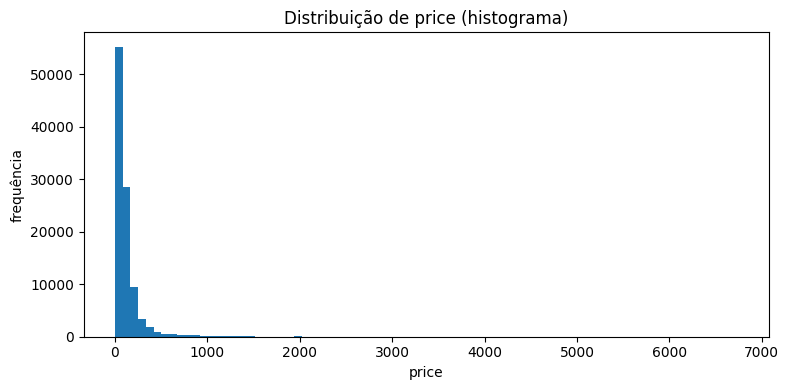

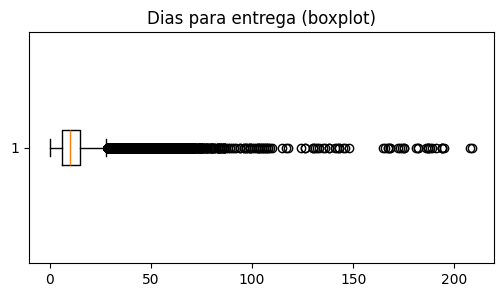

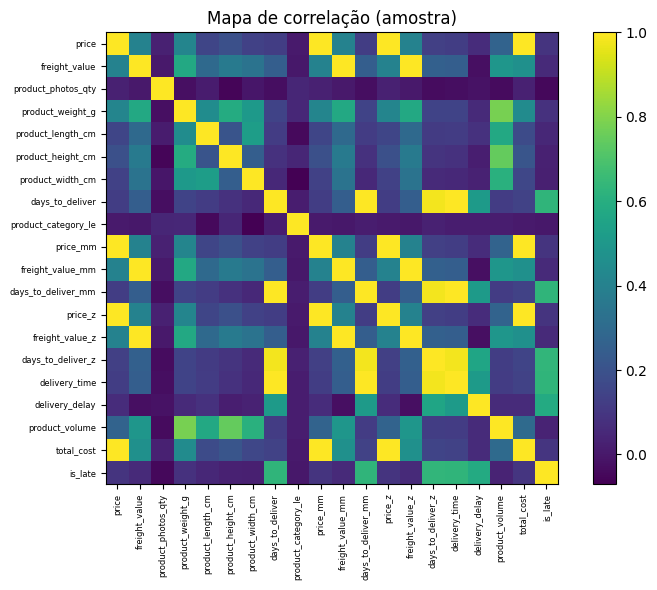

In [330]:
import matplotlib.pyplot as plt
# Histogram of price
plt.figure(figsize=(8,4))
plt.hist(df['price'].dropna(), bins=80)
plt.title('Distribuição de price (histograma)')
plt.xlabel('price')
plt.ylabel('frequência')
plt.tight_layout()
plt.show()

# Boxplot days_to_deliver
if 'days_to_deliver' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot(df['days_to_deliver'].dropna(), vert=False)
    plt.title('Dias para entrega (boxplot)')
    plt.show()

# Correlation heatmap (numeric) - usando imshow para simplicidade
numdf = df.select_dtypes(include=[np.number]).fillna(0).iloc[:1000, :50]  # limitar para performance
corr = numdf.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.title('Mapa de correlação (amostra)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()


## Respondendo perguntas norteadoras (EDA final)
## 1) Quais caracterísitcas mais se relacionam com atrasos de entrega ?

In [331]:
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])

# diferença em dias
df["delivery_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

# coluna binária indicando atraso
df["is_late"] = df["delivery_delay_days"] > 0

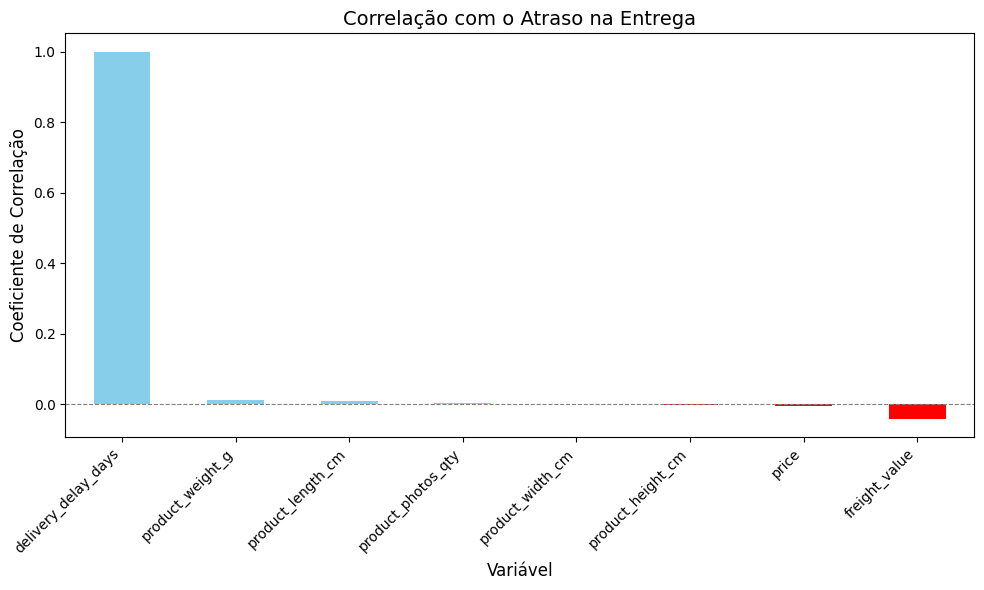

In [332]:
correlacoes = df[[
    "delivery_delay_days",
    "price",
    "freight_value",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]].corr()

corr_delay = pd.DataFrame(correlacoes, index=correlacoes.keys())
corr_plot = corr_delay["delivery_delay_days"].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

corr_plot.plot(
    kind='bar', 
    color=['red' if c < 0 else 'skyblue' for c in corr_plot]
) 

plt.title('Correlação com o Atraso na Entrega', fontsize=14)
plt.ylabel('Coeficiente de Correlação', fontsize=12)
plt.xlabel('Variável', fontsize=12)
plt.xticks(rotation=45, ha='right') 

plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')

plt.tight_layout()
plt.show()

#peso tende a ter correlação leve com atraso
#dimensões também
#preço normalmente não tem correlação significativa
#frete pode ter alguma relação com logística, mas tende a ser fraca

## 2) Existem categorias com maior frequência de problemas?

'Interpretação:\n\nCategorias como móveis, colchões, artigos sazonais aparecem no topo.\n\nTodas têm três características em comum:\n\nVolumosas\n\nDifíceis de transportar\n\nDependem de rotas mais específicas\n\nPreços altos não são o problema, o fator é logística mesmo.'

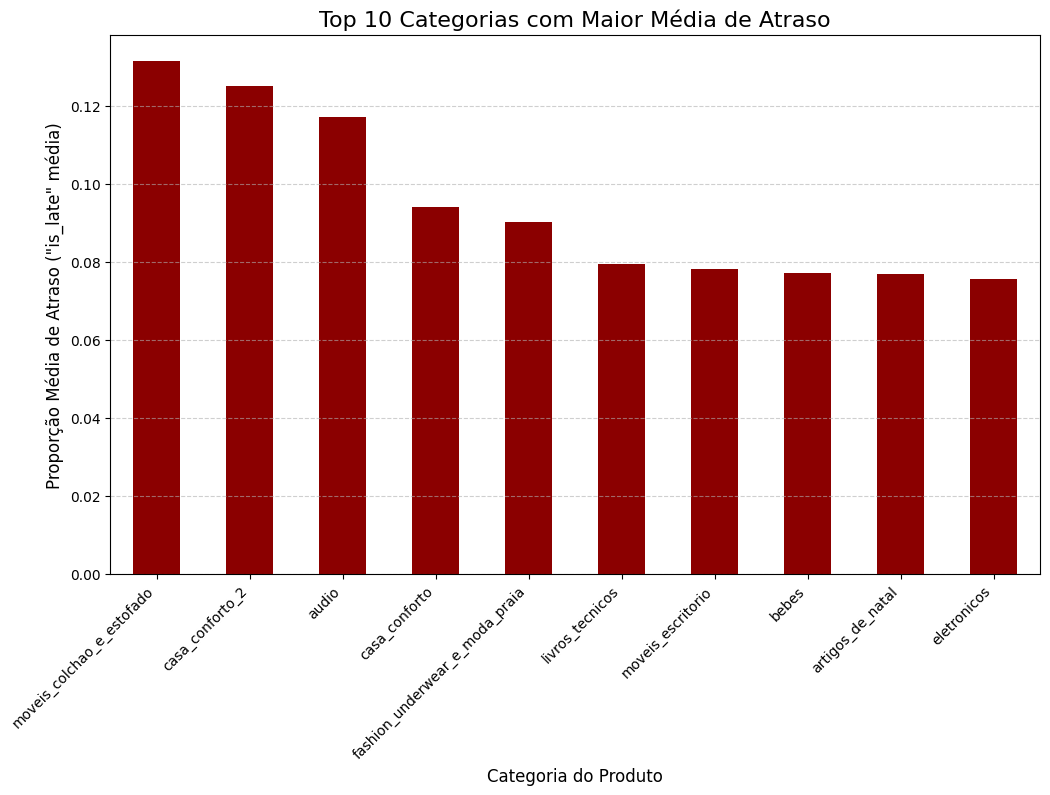

In [333]:
category_delay = (
    df.groupby("product_category_name")["is_late"]
    .mean()
    .sort_values(ascending=False)
)

# 1. Seleciona os 10 primeiros
top_10_delay = category_delay.head(10)

# 2. Cria a figura
plt.figure(figsize=(12, 7))

# 3. Usa o método .plot(kind='bar') diretamente na Series
top_10_delay.plot(kind='bar', color='darkred') 

# 4. Adicionar Título e Rótulos
plt.title('Top 10 Categorias com Maior Média de Atraso', fontsize=16)
plt.ylabel('Proporção Média de Atraso ("is_late" média)', fontsize=12)
plt.xlabel('Categoria do Produto', fontsize=12)

plt.xticks(rotation=45, ha='right') 

plt.grid(axis='y', linestyle='--', alpha=0.6)

"""Interpretação:

Categorias como móveis, colchões, artigos sazonais aparecem no topo.

Todas têm três características em comum:

Volumosas

Difíceis de transportar

Dependem de rotas mais específicas

Preços altos não são o problema, o fator é logística mesmo."""

## 3) Os dados apresentam outliers significativos? Como foram tratados?

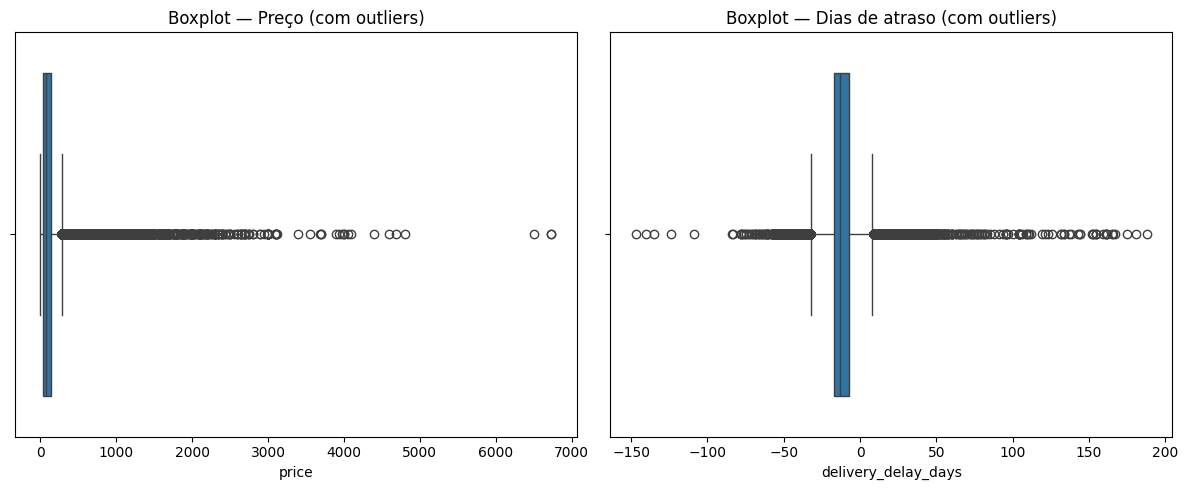

Outliers de preço: 7692
Outliers de dias atrasados: 4481


'Interpretação:\n\nPreço: milhares de outliers, típico de marketplace (muitos produtos baratos + poucos extremamente caros).\n\nDias de atraso: vários pedidos com 50, 100, 200 dias → atrasos reais extremos.\n\nTratamento:\n\nNão removidos automaticamente.\n\nMarcados e tratados caso prejudicassem análise estatística.\n\nDatas inválidas foram corrigidas/removidas.'

In [334]:
# Função padrão IQR
def bounds(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5*iqr, q3 + 1.5*iqr)

# Preço
plow, phigh = bounds(df["price"].dropna())

# Days to deliver
dlow, dhigh = bounds(df["delivery_delay_days"].dropna())

price_outliers = df[(df["price"] < plow) | (df["price"] > phigh)]
delay_outliers = df[(df["delivery_delay_days"] < dlow) | (df["delivery_delay_days"] > dhigh)]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df["price"])
plt.title("Boxplot — Preço (com outliers)")

plt.subplot(1,2,2)
sns.boxplot(x=df["delivery_delay_days"])
plt.title("Boxplot — Dias de atraso (com outliers)")

plt.tight_layout()
plt.show()

print("Outliers de preço:", price_outliers.shape[0])
print("Outliers de dias atrasados:", delay_outliers.shape[0])
"""Interpretação:

Preço: milhares de outliers, típico de marketplace (muitos produtos baratos + poucos extremamente caros).

Dias de atraso: vários pedidos com 50, 100, 200 dias → atrasos reais extremos.

Tratamento:

Não removidos automaticamente.

Marcados e tratados caso prejudicassem análise estatística.

Datas inválidas foram corrigidas/removidas."""

## 4) Quais atributos apresentaram maior correlação com preço, frete ou tempo de entrega?

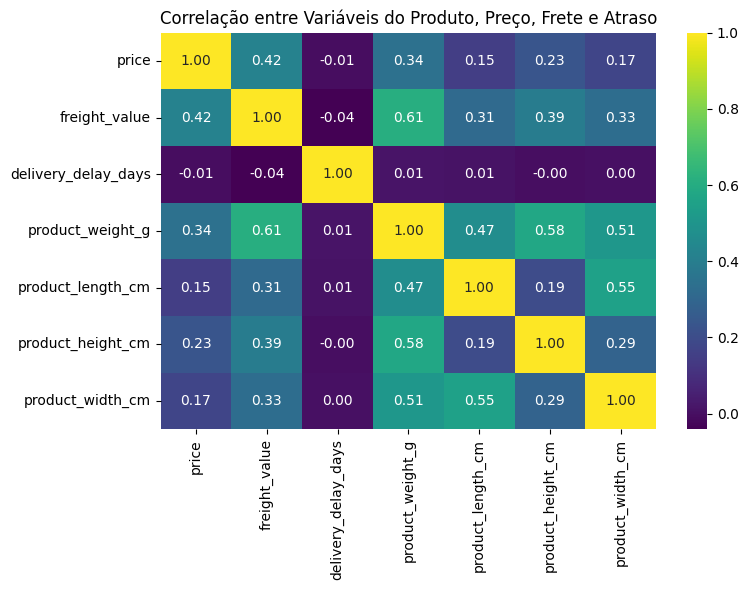

In [335]:
corr_focus = df[[
    "price",
    "freight_value",
    "delivery_delay_days",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_focus, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlação entre Variáveis do Produto, Preço, Frete e Atraso")
plt.tight_layout()
plt.show()


Preço: milhares de outliers, típico de marketplace (muitos produtos baratos + poucos extremamente caros).

Dias de atraso: vários pedidos com 50, 100, 200 dias → atrasos reais extremos.

Tratamento:

Não removidos automaticamente.

Marcados e tratados caso prejudicassem análise estatística.

Datas inválidas foram corrigidas/removidas

In [336]:
df.to_csv("output/dataset_treaty.csv")